## 模型&分词器
- 模型
- 分词器
- Token embedding 

### 模型
除了像之前使用 AutoModel 根据 checkpoint 自动加载模型以外，我们也可以直接使用模型对应的 Model 类，例如 BERT 对应的就是 BertModel：
```
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")
```

#### 加载模型
```
model = BertModel.from_pretrained("./models/bert/")

```
Model.from_pretrained() 会自动缓存下载的模型权重，默认保存到 ~/.cache/huggingface/transformers，我们也可以通过 HF_HOME 环境变量自定义缓存目录。
>由于 checkpoint 名称加载方式需要连接网络，因此在大部分情况下我们都会采用本地路径的方式加载模型。

#### 保存模型
```
model = AutoModel.from_pretrained("bert-base-cased")
model.save_pretrained("./models/bert-base-cased/")

```

这会在保存路径下创建两个文件：
- config.json：模型配置文件，存储模型结构参数，例如 Transformer 层数、特征空间维度等；
- pytorch_model.bin：又称为 state dictionary，存储模型的权重。

配置文件记录模型的结构，模型权重记录模型的参数


### 分词器
将文本转换为数字，这个过程被称为编码 (Encoding)，其包含两个步骤：
- 使用分词器 (tokenizer) 将文本按词、子词、字符切分为 tokens；
- 将所有的 token 映射到对应的 token ID。

#### 分词策略
根据切分粒度的不同，分词策略可以分为以下几种：
- 按词切分 (Word-based)

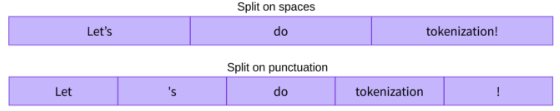

例如直接利用 Python 的 split() 函数按空格进行分词：

```
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)
['Jim', 'Henson', 'was', 'a', 'puppeteer']
```
这种策略的问题是会将文本中所有出现过的独立片段都作为不同的 token，从而产生巨大的词表

当遇到不在词表中的词时，分词器会使用一个专门的[UNK] token 来表示它是 unknown 的。显然，如果分词结果中包含很多[UNK]就意味着丢失了很多文本信息，因此一个好的分词策略，应该尽可能不出现 unknown token

- 按字符切分 (Character-based)

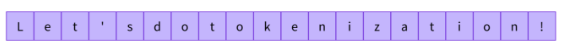

这种策略把文本切分为字符而不是词语，这样就只会产生一个非常小的词表，并且很少会出现词表外的 tokens。

但是从直觉上来看，字符本身并没有太大的意义，因此将文本切分为字符之后就会变得不容易理解。

因此现在广泛采用的是一种同时结合了按词切分和按字符切分的方式——按子词切分 (Subword tokenization)。

- **按子词切分 (Subword)** ***
高频词直接保留，低频词被切分为更有意义的子词。例如 “annoyingly” 是一个低频词，可以切分为 “annoying” 和 “ly”，这两个子词不仅出现频率更高，而且词义也得以保留。下图展示了对 “Let’s do tokenization!“ 按子词切分的结果：

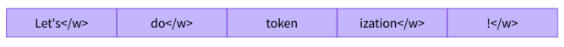

可以看到，“tokenization” 被切分为了 “token” 和 “ization”，不仅保留了语义，而且只用两个 token 就表示了一个长词。这种策略只用一个较小的词表就可以覆盖绝大部分文本，基本不会产生 unknown token

#### 加载与保存分词器
分词器的加载与保存与模型相似，使用 Tokenizer.from_pretrained() 和 Tokenizer.save_pretrained() 函数。例如加载并保存 BERT 模型的分词器：

```
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer.save_pretrained("./models/bert-base-cased/")
```

在大部分情况下我们都应该使用 AutoTokenizer 来加载分词器(包含了优化后的快速分词器）：

```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer.save_pretrained("./models/bert-base-cased/")
```

调用 Tokenizer.save_pretrained() 函数会在保存路径下创建三个文件：

- special_tokens_map.json：映射文件，里面包含 unknown token 等特殊字符的映射关系；
- tokenizer_config.json：分词器配置文件，存储构建分词器需要的参数；
- vocab.txt：词表，一行一个 token，行号就是对应的 token ID（从 0 开始）。

#### 编码与解码文本
前面说过，文本编码 (Encoding) 过程包含两个步骤：

- 分词：使用分词器按某种策略将文本切分为 tokens；
- 映射：将 tokens 转化为对应的 token IDs。
下面我们首先使用 BERT 分词器来对文本进行分词：
```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']

```
可以看到，BERT 分词器采用的是词切分策略，它会不断切分词语直到获得词表中的 token，例如 “transformer” 会被切分为 “transform” 和 “##er”。

然后，我们通过 convert_tokens_to_ids() 将切分出的 tokens 转换为对应的 token IDs：

```
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]
```
还可以通过 encode() 函数将这两个步骤合并，并且 encode() 会自动添加模型需要的特殊 token，例如 BERT 分词器会分别在序列的首尾添加[CLS]和 [SEP]：

```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
sequence_ids = tokenizer.encode(sequence)

print(sequence_ids)

[101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102]

```

其中 101 和 102 分别是[CLS]和 [SEP]对应的 token IDs。

##### 分词实操
```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_text = tokenizer("Using a Transformer network is simple")
print(tokenized_text)

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
```

文本解码 (Decoding) 与编码相反，负责将 token IDs 转换回原来的字符串。注意，解码过程不是简单地将 token IDs 映射回 tokens，还需要合并那些被分为多个 token 的单词。下面我们通过 decode() 函数解码前面生成的 token IDs：

```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

decoded_string = tokenizer.decode([101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102])
print(decoded_string)

result:
Using a transformer network is simple
[CLS] Using a Transformer network is simple [SEP]

```

#### 处理多段文本
现实场景中，我们往往会同时处理多段文本，而且模型也只接受批 (batch) 数据作为输入:

```
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print("Inputs Keys:\n", tokenized_inputs.keys())
print("\nInput IDs:\n", tokenized_inputs["input_ids"])

output = model(**tokenized_inputs)
print("\nLogits:\n", output.logits)


Inputs Keys:
 dict_keys(['input_ids', 'attention_mask'])

Input IDs:
tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])

Logits:
tensor([[-1.5607,  1.6123]], grad_fn=<AddmmBackward0>)

```

可以看到，分词器输出的结果中不仅包含 token IDs（input_ids），还会包含模型需要的其他输入项。前面我们之所以只输入 token IDs 模型也能正常运行，是因为它自动地补全了其他的输入项

#### 使用分词器(一步到位)***

正如前面所说，在实际使用时，我们应该直接使用分词器来完成包括分词、转换 token IDs、Padding、构建 Attention Mask、截断等操作：
```
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "So have I!"
]

model_inputs = tokenizer(sequences, padding="longest",truncation=True,return_tensors="pt")
print(model_inputs)

model_inputs = tokenizer(sequences, padding="max_length",truncation=True,return_tensors="np")
print(model_inputs)

{'input_ids': [
    [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 
    [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
 'attention_mask': [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
}

{'input_ids': [
    [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, ...], 
    [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, ...]], 
 'attention_mask': [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...], 
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]]
}
```

可以看到，分词器的输出包含了模型需要的所有输入项。对于 DistilBERT 模型，就是 input IDs（input_ids）和 Attention Mask（attention_mask）。

Padding 操作通过 padding 参数来控制：

- padding="longest"： 将序列填充到当前 batch 中最长序列的长度；
- padding="max_length"：将所有序列填充到模型能够接受的最大长度，例如 BERT 模型就是 512。

truncation :截断操作通过 truncation 参数来控制，如果 truncation=True，那么大于模型最大接受长度的序列都会被截断

return_tensors:分词器还可以通过 return_tensors 参数指定返回的张量格式：设为 pt 则返回 PyTorch 张量；tf 则返回 TensorFlow 张量，np 则返回 NumPy 数组

#### 编码句子对
除了对单段文本进行编码以外（batch 只是并行地编码多个单段文本），对于 BERT 等包含“句子对”预训练任务的模型，它们的分词器都支持对“句子对”进行编码:
```
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

inputs = tokenizer("This is the first sentence.", "This is the second one.")
print(inputs)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"])
print(tokens)


{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

['[CLS]', 'this', 'is', 'the', 'first', 'sentence', '.', '[SEP]', 'this', 'is', 'the', 'second', 'one', '.', '[SEP]']

```

此时分词器会使用[SEP]token 拼接两个句子，输出形式为“[CLS] sentence1 [SEP] sentence2 [SEP]”的 token 序列，这也是 BERT 模型预期的“句子对”输入格式。

返回结果中除了前面我们介绍过的 input_ids 和 attention_mask 之外，还包含了一个 token_type_ids 项，用于标记哪些 token 属于第一个句子，哪些属于第二个句子。如果我们将上面例子中的 token_type_ids 项与 token 序列对齐：

```
['[CLS]', 'this', 'is', 'the', 'first', 'sentence', '.', '[SEP]', 'this', 'is', 'the', 'second', 'one', '.', '[SEP]']
[      0,      0,    0,     0,       0,          0,   0,       0,      1,    1,     1,        1,     1,   1,       1]
```

就可以看到第一个句子“[CLS] sentence1 [SEP]”所有 token 的 type ID 都为 0，而第二个句子“sentence2 [SEP]”对应的 token type ID 都为 1。

>如果我们选择其他模型，分词器的输出不一定会包含 token_type_ids 项（例如 DistilBERT 模型）。分词器只需保证输出格式与模型预训练时的输入一致即可。

#### Token embedding 初始化
如果训练语料较少，甚至是只有很少语料的 few-shot learning 场景下，这种做法就存在问题。研究表明，在训练数据不够多的情况下，这些新添加 token 的 embedding 只会在初始值附近小幅波动。换句话说，即使经过训练，它们的值事实上还是随机的。

##### 直接赋值
因此，在很多情况下，我们需要手工初始化新添加 token 的 embedding，这可以通过直接对 embedding 矩阵赋值来实现。例如我们将上面例子中两个新 token 的 embedding 都初始化为全零向量：

```
import torch

with torch.no_grad():
    model.embeddings.word_embeddings.weight[-2:, :] = torch.zeros([2, model.config.hidden_size], requires_grad=True)
print(model.embeddings.word_embeddings.weight[-2:, :])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SliceBackward0>)
```
>注意，初始化 embedding 的过程并不可导，因此这里通过 torch.no_grad() 暂停梯度的计算。

现实场景中，更为常见的做法是使用已有 token 的 embedding 来初始化新添加 token。我们可以将 [ENT_START] 和 [ENT_END] 的值都初始化为“entity” token 对应的 embedding:

```

import torch

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModel.from_pretrained(checkpoint)
token_id = tokenizer.convert_tokens_to_ids('entity')
token_embedding = model.embeddings.word_embeddings.weight[token_id]

print(token_id)
num_added_toks = tokenizer.add_tokens(["new_token1", "my_new-token2"])

with torch.no_grad():
    for i in range(1, num_added_toks+1):
        model.embeddings.word_embeddings.weight[-i:, :] = token_embedding.clone().detach().requires_grad_(True)
print(model.embeddings.word_embeddings.weight[-2:, :])

9178
tensor([[-0.0039, -0.0131, -0.0946,  ..., -0.0223,  0.0107, -0.0419],
        [-0.0039, -0.0131, -0.0946,  ..., -0.0223,  0.0107, -0.0419]],
       grad_fn=<SliceBackward0>)
```
>因为 token ID 就是 token 在 embedding 矩阵中的索引，因此这里我们直接通过 weight[token_id] 取出“entity”对应的 embedding。

可以看到最终结果符合我们的预期，[ENT_START] 和 [ENT_END] 被初始化为相同的 embedding。

## 参考
### 源码
https://colab.research.google.com/drive/1aAaO5vimEDVOFSDiYEB22tiwOg8n13jD#scrollTo=gDtJBv6JH-Rl


### 引用
- 1、https://transformers.run/intro/2021-12-11-transformers-note-2/